In [9]:
!echo "Last updated: `date`"

Last updated: Wed Aug  5 07:39:43 PDT 2020


## Model

$$
\begin{eqnarray}
y_i \mid z_i &\sim& \text{Bernoulli}(\text{sigmoid}(z_i)) \\
\mathbf{z} \mid \rho, \alpha &\sim& \text{MvNormal}(\mathbf{0}, K_{\alpha, \rho}(\mathbf{X})) \\
\alpha &\sim& \text{LogNormal}(0, 0.1) \\
\rho &\sim& \text{LogNormal}(0, 1) \\
\end{eqnarray}
$$

**Note:** The latent GP should be centered at 0, because when there is no data, $P(y_i = 1)$ should be $0.5$.

In [168]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pystan
import sys
sys.path.append('../util')
from distance import euclidean
from scipy.stats import norm
from tqdm import trange

In [19]:
np.random.seed(1)

In [20]:
# Read data.
path_to_data = '../data/gp-binary-data-N100.json'
simdata = json.load(open(path_to_data))

# Store data.
X = np.stack([simdata['x1'], simdata['x2']], axis=-1)
y = np.array(simdata['y'])

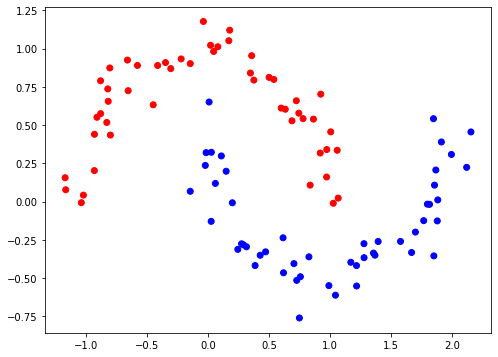

In [196]:
def plot_data(X, y):
    colors = np.array(['red', 'blue'])
    plt.scatter(X[:, 0], X[:, 1], color=colors[y])
    plt.show()
    
plt.figure(figsize=(8, 6))
plot_data(X, y)

In [45]:
model_code = """
data {
  int<lower=0> N;
  int<lower=0> M;
  int<lower=0> P;
  int<lower=0, upper=1> y[N];
  matrix[N, P] X;
  matrix[M, P] W;
  real m_K;
  real<lower=0> s_K;
}

transformed data {
  matrix[N, M] D;  // Distance matrix.

  // Create distance matrix.
  for (n in 1:N) for (m in 1:M) {
    D[n, m] = distance(X[n, :], W[m, :]);
  }
}

parameters {
  vector[M] z;  // White noise process.
  real<lower=0> sigma_K;  // Range parameter in covariance.
}

model {
  matrix[N, M] K;  // Kernel matrix.
  vector[N] f; // Latent function.

  // Priors.
  z ~ normal(0, 1);
  sigma_K ~ lognormal(0, 1);

  // Populate kernel matrix.
  for (n in 1:N) for (m in 1:M) {
    K[n, m] = exp(normal_lpdf(D[n, m] | 0, sigma_K));
  }
  
  // Latent function.
  f = K * z;
  
  // Model.
  y ~ bernoulli_logit(f);
}
"""

In [46]:
# Compile model. This takes about a minute.
%time sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d8335f1ddc550deb161d3664e2d8bf6 NOW.


CPU times: user 773 ms, sys: 48.2 ms, total: 821 ms
Wall time: 50 s


In [57]:
# Data dictionary.
def create_stan_data(X, y, M, m_K=0, s_K=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    N, P = X.shape
    assert (N, ) == y.shape
    
    W = np.stack([np.random.uniform(X[:, d].min(), X[:, d].max(), M) for d in range(P)], axis=1)
    
    return dict(y=y, X=X, M=M, N=N, P=P, m_K=m_K, s_K=s_K, W=W)

In [81]:
# Generate stan data dictionary.
stan_data = create_stan_data(X, y, 30, seed=1)

In [82]:
%%time
# Fit via HMC
hmc_fit = sm.sampling(data=stan_data, iter=2000, chains=1, warmup=1000, thin=1,
                      seed=1, algorithm='HMC', control=dict(stepsize=0.01, int_time=1))

CPU times: user 2.09 s, sys: 0 ns, total: 2.09 s
Wall time: 2.08 s


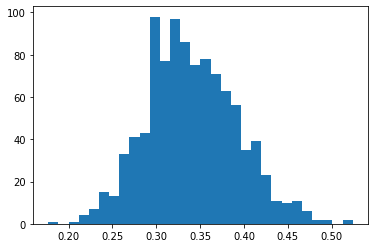

In [83]:
plt.hist(hmc_fit['sigma_K'], bins=30);

In [177]:
# D =  euclidean(X, stan_data['W'])
X_new = np.stack([np.random.uniform(X[:, d].min(), X[:, d].max(), 1000) for d in range(2)], axis=1)
X_all = np.concatenate([X_new, X], axis=0)
D = euclidean(X_all, stan_data['W'])
N = X.shape[0]
M = X_new.shape[0]

In [178]:
def gp_predict(z, sigma_K):
    K = norm.pdf(D/sigma_K)
    KK = np.matmul(K, K.T)
    K_new_old = KK[:M, M:]
    K_old_inv = np.linalg.inv(KK[M:, M:])
    C = K_new_old.dot(K_old_inv)
    f = K[M:, :].dot(z)
    mu = C.dot(f)
    S = KK[:M, :M] - C.dot(K_new_old.T)
    return np.random.multivariate_normal(mu, S)

sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [179]:
preds = np.stack([gp_predict(hmc_fit['z'][i, :], hmc_fit['sigma_K'][i]) for i in trange(100)])
preds



  0%|          | 0/100 [00:00<?, ?it/s]/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

covariance is not positive-semidefinite.



  1%|          | 1/100 [00:00<00:36,  2.71it/s]

  2%|▏         | 2/100 [00:00<00:36,  2.71it/s]

  3%|▎         | 3/100 [00:01<00:35,  2.73it/s]

  4%|▍         | 4/100 [00:01<00:35,  2.73it/s]

  5%|▌         | 5/100 [00:01<00:34,  2.74it/s]

  6%|▌         | 6/100 [00:02<00:34,  2.73it/s]

  7%|▋         | 7/100 [00:02<00:34,  2.73it/s]

  8%|▊         | 8/100 [00:02<00:33,  2.73it/s]

  9%|▉         | 9/100 [00:03<00:33,  2.75it/s]

 10%|█         | 10/100 [00:03<00:32,  2.74it/s]

 11%|█         | 11/100 [00:04<00:32,  2.73it/s]

 12%|█▏        | 12/100 [00:04<00:32,  2.73it/s]

 13%|█▎        | 13/100 [00:04<00:31,  2.74it/s]

 14%|█▍        | 14/100 [00:05<00:31,  2.70it/s]

 15%|█▌        | 15/100 [00:05<00:31,  2.71it/s]

 16%|█▌        | 16/100 [00:05<00:30,  2.73it/s]

 17%|█▋   

(100, 1000)

/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

overflow encountered in exp



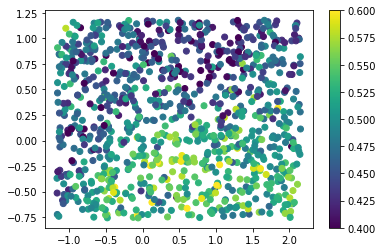

In [208]:
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
plt.scatter(X_new[:, 0], X_new[:, 1], c=sigmoid(preds).mean(0), vmin=0.4, vmax=0.6)
# plot_data(X, y)
plt.colorbar();

/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning:

overflow encountered in exp

  2%|▏         | 23/1000 [09:36<6:48:03, 25.06s/it]


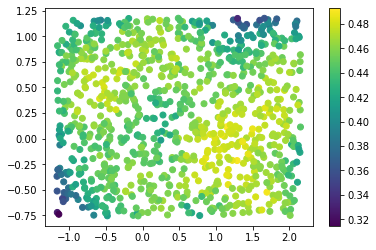

In [211]:
plt.scatter(X_new[:, 0], X_new[:, 1], c=sigmoid(preds).std(0))
plt.colorbar();